## A minimal example showing the code used train the standard VAE model in the deep learning project:
Project 3: *Generative modelling for phenotypic profiling using Variational Autoencoders*

In [3]:
# Load necessary packages
import os
from plotting import make_vae_plots
import re
import random
import time
from collections import defaultdict
from typing import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
#import seaborn as sns
import pandas as pd
import math 
import torch
import torchvision.utils as vutils
from torch import nn, Tensor, sigmoid
from torch.nn.functional import softplus
from torch.distributions import Distribution, Bernoulli
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from model_VAE_plus import PrintSize, Flatten, UnFlatten
from model_VAE_plus import ReparameterizedDiagonalGaussian
from model_VAE_plus import ReparameterizedDiagonalGaussianWithSigmoid
from model_VAE_plus import VariationalAutoencoder, VariationalInference

In [4]:
print(torch.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

print("PyTorch Version {}" .format(torch.__version__))
print("Cuda Version {}" .format(torch.version.cuda))
print("CUDNN Version {}" .format(torch.backends.cudnn.version()))

1.12.1
>> Using device: cpu
PyTorch Version 1.12.1
Cuda Version None
CUDNN Version None


In [6]:
name = 'vae'
result_dir = 'results_vanilla_vae_1/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
    
# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
f = open(result_dir + 'random_seed.txt', "w")
f.write(str(manualSeed))
f.close()
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  9654


In [7]:
### Evalutation and plotting functions
def evaluation(test_loader, name=None, model_best=None, epoch=None,
               device='cpu'):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')
        model_best = model_best.to(device)

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, (test_batch, test_target) in enumerate(test_loader):
        test_batch = test_batch.to(device)
        
        #loss_t = model_best.forward(test_batch, reduction='sum')
        loss_t, xhat, diagnostics, outputs = vi(model_best, test_batch)
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss

def samples_real(name, test_loader):
    # REAL-------
    num_x = 3
    num_y = 4
    x = next(iter(test_loader))[0].detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.transpose(x[i].reshape((3, 68, 68)), (1, 2, 0))
        ax.imshow(plottable_image)
        ax.axis('off')

    plt.savefig(name + '_real_images.png', bbox_inches='tight')
    plt.close()
    

def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader))[0].detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.cpu()
    model_best.eval()

    num_x = 4
    num_y = 4
    
    px = model_best.sample_from_prior(batch_size=num_x * num_y)['px']
    x_samples = px.sample()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x_samples[i], (3, 68, 68)).permute(1, 2, 0)
        ax.imshow(plottable_image)
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.png', bbox_inches='tight')
    plt.close()
    

def plot_curve(name, nll_val, x_label="epochs", y_label="nll"):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.savefig(name + '.png', bbox_inches='tight')
    plt.close()

### Parameters

In [24]:
# Initialize parameters
# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 6

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 68

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector
latent_features = 100

# Size of feature maps in VAE encoder and decoder
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Max patience for early stopping
max_patience = 100

# Learning rate for optimizers
lr_VAE = 1e-4

# Beta hyperparam for VAE loss
beta = 1.0

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# The value the DMSO category is downsampled to
downsample_value = 16000

# Amount of data used for training, validation and testing
data_prct = 1
train_prct = 0.95

### Dataset
The dataset contain 68x68 images of single cells treated with different compounds. For each of the utilized compounds there is an associated mechanism of action (MOA), which describes how the compound it affecting the cell. There are 12 different MOA classes and a control class called DSMO. Here only a small percentage of the full dataset (1000 images) will be utilized.

In [25]:
# Get current working directory
DIR = os.getcwd()

# Load metadata table
start_time = time.time()
metadata = pd.read_csv("../data/metadata_mini.csv")
print("pd.read_csv wiht pyarrow took %s seconds" % (time.time() - start_time))

pd.read_csv wiht pyarrow took 0.1536881923675537 seconds


In [26]:
metadata.groupby("moa").size().reset_index(name='counts').sort_values(by="counts", ascending=False)

,moa,counts
10,Microtubule stabilizers,387
4,DNA damage,81
1,Aurora kinase inhibitors,79
3,DMSO,65
6,Eg5 inhibitors,60
8,Kinase inhibitors,60
7,Epithelial,59
9,Microtubule destabilizers,54
12,Protein synthesis,44
0,Actin disruptors,38


In [27]:
# Map from class name to class index
classes = {index: name for name, index in enumerate(metadata["moa"].unique())}
classes_inv = {v: k for k, v in classes.items()}

In [28]:
# Map from class name to class index
classes = {index: name for name, index in enumerate(metadata["moa"].unique())}
classes_inv = {v: k for k, v in classes.items()}
classes

{'Kinase inhibitors': 0,
 'Eg5 inhibitors': 1,
 'Microtubule stabilizers': 2,
 'DMSO': 3,
 'Microtubule destabilizers': 4,
 'Protein synthesis': 5,
 'Actin disruptors': 6,
 'Epithelial': 7,
 'Aurora kinase inhibitors': 8,
 'DNA damage': 9,
 'Protein degradation': 10,
 'Cholesterol-lowering': 11,
 'DNA replication': 12}

In [29]:
metadata

,Unnamed: 0.1,level_0,index,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,...,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
0,0,191846,406091,406091,3080,Week7_7__F04_s2_w1C7A8F9CA-F54B-40DE-9EEE-7E71...,125,Week7_7__F04_s2_w1C7A8F9CA-F54B-40DE-9EEE-7E71...,7,3050,...,Week7_7__F04_s2_w2CAF44A0C-1EDB-41CE-8480-91F8...,Week7_34661,Week7_7__F04_s2_w4F9D05EDC-B012-4F3F-B558-5C56...,Week7_34661,Week7_34661,F04,2,PD-169316,10.00,Kinase inhibitors
1,1,2787,5545,5545,525,Week10_200907_C09_s3_w19437640F-29D0-42B8-9C85...,83,Week10_200907_C09_s3_w19437640F-29D0-42B8-9C85...,0,71,...,Week10_200907_C09_s3_w29B6DE609-DB82-47FD-A103...,Week10_40111,Week10_200907_C09_s3_w44DE7F152-E698-48C6-87F2...,Week10_40111,Week10_40111,C09,1,AZ138,0.03,Eg5 inhibitors
2,2,159666,309483,309483,2387,Week5_130707_E02_s4_w1CD0139A5-C58F-4E4E-BE44-...,36,Week5_130707_E02_s4_w1CD0139A5-C58F-4E4E-BE44-...,5,3004,...,Week5_130707_E02_s4_w208EA0654-74FC-40AB-800F-...,Week5_29301,Week5_130707_E02_s4_w495146015-FBA6-406D-BD4F-...,Week5_29301,Week5_29301,E02,1,taxol,0.30,Microtubule stabilizers
3,3,153731,292273,292273,2348,Week5_130707_D11_s2_w16C0AA106-F223-4CA3-976B-...,48,Week5_130707_D11_s2_w16C0AA106-F223-4CA3-976B-...,5,358,...,Week5_130707_D11_s2_w21FCEC64A-77E4-4257-8E5D-...,Week5_28921,Week5_130707_D11_s2_w46E781881-AAA6-4F65-9D1F-...,Week5_28921,Week5_28921,D11,2,taxol,0.30,Microtubule stabilizers
4,4,169436,343661,343661,2634,Week6_200607_D02_s4_w1021438BB-B36F-48B2-98DE-...,26,Week6_200607_D02_s4_w1021438BB-B36F-48B2-98DE-...,6,564,...,Week6_200607_D02_s4_w2E5B36F5D-7732-4B5B-86B1-...,Week6_31681,Week6_200607_D02_s4_w47065B016-72C5-4F2B-BDE2-...,Week6_31681,Week6_31681,D02,3,DMSO,0.00,DMSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,97113,183560,183560,2092,Week3_290607_F05_s2_w16BE8E365-50DA-470B-8D9B-...,150,Week3_290607_F05_s2_w16BE8E365-50DA-470B-8D9B-...,3,654,...,Week3_290607_F05_s2_w2185B8544-3831-4245-A00A-...,Week3_25461,Week3_290607_F05_s2_w47FBB3922-9DBE-450F-B484-...,Week3_25461,Week3_25461,F05,3,etoposide,3.00,DNA damage
996,996,171410,353345,353345,2593,Week6_200607_C11_s1_w10463464A-3744-4A1F-9083-...,38,Week6_200607_C11_s1_w10463464A-3744-4A1F-9083-...,6,2957,...,Week6_200607_C11_s1_w21D4F2DF2-F959-4696-B1DC-...,Week6_32121,Week6_200607_C11_s1_w4EBBCB968-9FAE-4424-97C4-...,Week6_32121,Week6_32121,C11,2,taxol,0.30,Microtubule stabilizers
997,997,27835,54679,54679,745,Week1_150607_B11_s1_w129C9B1A2-75C6-44AE-9E1D-...,8,Week1_150607_B11_s1_w129C9B1A2-75C6-44AE-9E1D-...,1,277,...,Week1_150607_B11_s1_w284256C54-8558-4EDF-8C81-...,Week1_22141,Week1_150607_B11_s1_w49853504B-D04D-45BE-945A-...,Week1_22141,Week1_22141,B11,2,taxol,0.30,Microtubule stabilizers
998,998,40876,75823,75823,736,Week1_150607_B06_s2_w12134F829-2C5E-4ED7-BA2B-...,149,Week1_150607_B06_s2_w12134F829-2C5E-4ED7-BA2B-...,1,2898,...,Week1_150607_B06_s2_w23FEAC940-8D8C-4735-A14E-...,Week1_22361,Week1_150607_B06_s2_w4899D2801-D3BC-45B8-8D35-...,Week1_22361,Week1_22361,B06,1,latrunculin B,1.00,Actin disruptors


In [30]:
# Dataloader class. Using the metadata table, images are sampled and 
# passed to VAE duing training
class SingleCellDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, images_folder, class_map, 
                 mode='train', transform = None):
        self.df = annotation_file
        self.images_folder = images_folder
        self.transform = transform
        self.class2index = class_map
            

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "Single_Cell_Image_Name"]
        label = self.class2index[self.df.loc[index, "moa"]]
        #subfolder = re.search("(.*)_", filename).group(1)
        image = np.load(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image.astype(np.float32))
        return image, label

In [31]:
# The loaders perform the actual work
#images_folder = '/zhome/70/5/14854/nobackup/deeplearningf22/bbbc021/singlecell/singh_cp_pipeline_singlecell_images/'
images_folder = "../data/"
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x/x.max()),
    ]
)

train_set = SingleCellDataset(images_folder=images_folder, 
                              annotation_file=metadata, 
                              transform=train_transforms,
                              class_map=classes)

# Define the size of the train, validation and test datasets
data_amount = int(len(metadata) * data_prct)
train_size = int(train_prct * data_amount)
val_size = (data_amount - train_size) // 2
test_size = (data_amount - train_size) // 2

indicies = torch.randperm(len(metadata))
train_indices = indicies[:train_size]
val_indicies = indicies[train_size:train_size+val_size]
test_indicies = indicies[train_size+val_size:train_size+val_size+test_size]

training_set = torch.utils.data.Subset(train_set, train_indices.tolist())
val_set = torch.utils.data.Subset(train_set, val_indicies.tolist())
testing_set = torch.utils.data.Subset(train_set, test_indicies.tolist())

training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, 
                                             shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle=True)

print(len(training_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

# Load a batch of images into memory
images, labels = next(iter(training_loader))

950
25
25


In [33]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

In [34]:
vi_test = VariationalInference(beta=1)
loss, xhat, diagnostics, outputs = vi_test(vae, images)
print(f"{'xhat':6} | shape: {list(xhat.shape)}")
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

Size: torch.Size([6, 64, 32, 32])
Size: torch.Size([6, 128, 16, 16])
Size: torch.Size([6, 256, 8, 8])
Size: torch.Size([6, 512, 4, 4])
Size: torch.Size([6, 200, 1, 1])
Size: torch.Size([6, 200])
Size: torch.Size([6, 512, 4, 4])
Size: torch.Size([6, 256, 8, 8])
Size: torch.Size([6, 128, 16, 16])
Size: torch.Size([6, 64, 32, 32])
Size: torch.Size([6, 6, 68, 68])
xhat   | shape: [6, 3, 68, 68]
loss   | mean =   2624.692, shape: []
elbo   | mean =  -2624.692, shape: [6]
log_px | mean =  -2616.127, shape: [6]
kl     | mean =      8.565, shape: [6]


In [35]:
name = 'vae'

from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
vae = VariationalAutoencoder(latent_features)

# Evaluator: Variational Inference
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=lr_VAE)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0
nll_val = []
elbo_loss = []
kl_loss = []
log_px_loss = []
train_loss = []
best_nll = 1000000.
patience = 0
step = 0
train_img_list = []
val_img_list = []

train_fixed, train_label_fixed = next(iter(val_loader))
train_fixed_b1, train_fixed_b2 = torch.split(train_fixed, split_size_or_sections=batch_size//2)
train_fixed_b1 = train_fixed_b1.reshape(batch_size//2, 3, 68, 68)
train_fixed_b1 = train_fixed_b1.to(device)

val_fixed, val_label_fixed = next(iter(val_loader))
val_fixed_b1, val_fixed_b2 = torch.split(val_fixed, split_size_or_sections=batch_size//2)
val_fixed_b1 = val_fixed_b1.reshape(batch_size//2, 3, 68, 68)
val_fixed_b1 = val_fixed_b1.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

>> Using device: cpu


### Training procedure

In [36]:
while epoch < num_epochs:
    epoch += 1
    print(f"{epoch} / {num_epochs}")
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for i, (x, y) in enumerate(training_loader):
        step += 1
        
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, xhat, diagnostics, outputs = vi(vae, x)

        elbo_loss.append(diagnostics['elbo'].mean().item())
        kl_loss.append(diagnostics['kl'].mean().item())
        log_px_loss.append(diagnostics['log_px'].mean().item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
        
        # Output training stats
        if step % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_VAE: %.4f'
                % (epoch, num_epochs, i, len(training_loader), loss.item()))

        # Check how the generator is doing by saving G's output on fixed_noise
        if (step % 100 == 0) or ((epoch == num_epochs-1) and (i == len(training_loader)-1)):
            with torch.no_grad():
                loss_elbo, xhat, diagnostics, outputs = vi(vae, train_fixed_b1)
                xhat = xhat.detach().cpu()
            train_img_list.append(vutils.make_grid(xhat, padding=2, normalize=True))

            with torch.no_grad():
                loss_elbo, xhat, diagnostics, outputs = vi(vae, val_fixed_b1)
                xhat = xhat.detach().cpu()
            val_img_list.append(vutils.make_grid(xhat, padding=2, normalize=True))
            
    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]
        
    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the validation loader
        x, y = next(iter(val_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss_val, xhat, diagnostics, outputs = vi(vae, x)
        nll_val.append(loss_val.cpu())  # save for plotting
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    if (step % 3000 == 0):
        filename = result_dir + f"vae_out_{epoch}.png"
        make_vae_plots(vae, x, y, outputs, training_data, validation_data, save_img = filename, save=True)

    if epoch == 1:
            print('saved!')
            torch.save(vae, result_dir + name + '.model')
            best_nll = loss_val
    else:
        samples_generated(result_dir + name, val_loader, extra_name="_epoch_" + str(epoch))
        if loss_val < best_nll:
            print('saved!')
            torch.save(vae, result_dir + name + '.model')
            best_nll = loss_val
            patience = 0
        else:
            patience = patience + 1
        
    if patience > max_patience:
        print("Max patience reached! Performing early stopping!")
        break

1 / 20
Size: torch.Size([6, 64, 32, 32])
Size: torch.Size([6, 128, 16, 16])
Size: torch.Size([6, 256, 8, 8])
Size: torch.Size([6, 512, 4, 4])
Size: torch.Size([6, 200, 1, 1])
Size: torch.Size([6, 200])
Size: torch.Size([6, 512, 4, 4])
Size: torch.Size([6, 256, 8, 8])
Size: torch.Size([6, 128, 16, 16])
Size: torch.Size([6, 64, 32, 32])
Size: torch.Size([6, 6, 68, 68])
[1/20][49/158]	Loss_VAE: 449.6034
[1/20][99/158]	Loss_VAE: 465.9996
[1/20][149/158]	Loss_VAE: 370.1766
saved!
2 / 20
[2/20][41/158]	Loss_VAE: 350.6896
[2/20][91/158]	Loss_VAE: 325.0014
[2/20][141/158]	Loss_VAE: 311.6554
3 / 20
[3/20][33/158]	Loss_VAE: 238.0685
[3/20][83/158]	Loss_VAE: 261.2084
[3/20][133/158]	Loss_VAE: 304.9829
saved!
4 / 20
[4/20][25/158]	Loss_VAE: 363.7906
[4/20][75/158]	Loss_VAE: 238.5400
[4/20][125/158]	Loss_VAE: 264.4758
saved!
5 / 20
[5/20][17/158]	Loss_VAE: 197.5639
[5/20][67/158]	Loss_VAE: 197.8989
[5/20][117/158]	Loss_VAE: 269.5578
6 / 20
[6/20][9/158]	Loss_VAE: 251.7620
[6/20][59/158]	Loss_VAE: 2

In [37]:
print('saved final model!')
torch.save(vae, result_dir + name + '_final.model')

make_vae_plots(vae, x, y, outputs, training_data, validation_data,
               save_img = result_dir + "vae_out_final.png", save=True)

saved final model!
Could not generate the plot of the latent sanples because of exception
name 'sns' is not defined


### Evaluation

FINAL LOSS: nll=25.85975128173828


IndexError: index 6 is out of bounds for axis 0 with size 6

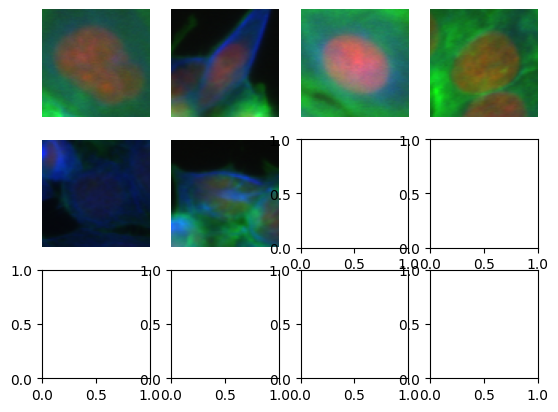

In [38]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader, device=device)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

In [ ]:
plot_curve(result_dir + name, nll_val)

plt.figure(figsize=(10,5))
plt.title("Elbo Loss During Training")
plt.plot(elbo_loss, label="Elbo")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(result_dir + 'elbo_training_loss.png', bbox_inches='tight')
plt.close()

plt.figure(figsize=(10,5))
plt.title("KL Loss During Training")
plt.plot(elbo_loss, label="KL")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(result_dir + 'kl_training_loss.png', bbox_inches='tight')
plt.close()

plt.figure(figsize=(10,5))
plt.title("Log(p(x|z)) Loss During Training")
plt.plot(elbo_loss, label="Log(p(x|z))")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(result_dir + 'log_px_training_loss.png', bbox_inches='tight')
plt.close()

#fig = plt.figure(figsize=(8,8))
#plt.axis("off")
#ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in train_img_list]
#ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
## saving to m4 using ffmpeg writer
#writervideo = animation.FFMpegWriter(fps=60)
#ani.save(result_dir + 'train_VAE_progression.mp4', writer=writervideo)
#plt.close()

#fig = plt.figure(figsize=(8,8))
#plt.axis("off")
#ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in val_img_list]
#ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
## saving to m4 using ffmpeg writer
#writervideo = animation.FFMpegWriter(fps=60)
#ani.save(result_dir + 'val_VAE_progression.mp4', writer=writervideo)
#plt.close()